In [1]:
from collections import Counter
import itertools
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure, show
import seaborn as sns
from scipy import sparse
from scipy.sparse import linalg 
from scipy.sparse import dok_matrix
from scipy.sparse import csr_array
from scipy.sparse import find
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from itertools import zip_longest

df = pd.read_csv('../input/abcnews-date-text.csv')
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))
df['tokenized'] = df.headline_text.str.split(' ')

df['length'] = df.tokenized.map(len)
df = df.loc[df.length > 1]


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#explode and sanitize

ex = df.explode('tokenized')

ex = ex.loc[ex.tokenized.str.len() > 2]

ex = ex.loc[~ex.tokenized.isin(stopwords_set)]

In [3]:
#ceate dictionary of 116795 unique words

dictionary = ex.tokenized.drop_duplicates().sample(frac=1)

dictionary = pd.Series(dictionary.tolist(), name='words')

dictionary = dictionary.to_frame()

dictionary_lookup = dictionary.to_dict()['words']

dictionary_encoder = dictionary.copy(deep=False)

dictionary_encoder['encode'] = dictionary_encoder.index + 1

dictionary_encoder = dictionary_encoder.set_index('words')

dictionary_encoder = dictionary_encoder.to_dict()['encode']

encode = ex.tokenized.map(dictionary_encoder.get).to_frame()


In [4]:
#reduced grouping to series and aggregated to tuple
#improved from 30s to 20s
#longest sentence is 12 words
encode.index.astype('int')
encode.tokenized.astype('int')
docs = encode.tokenized.groupby(level=0).agg(tuple)


In [5]:

encoded_docs = list(zip(*zip_longest(*docs.to_list(), fillvalue=0)))

encoded_docs = csr_array(encoded_docs, dtype=int)

row_column_code = find(encoded_docs)

word_sorted_index = row_column_code[2].argsort()

doc_word = np.array([row_column_code[0][word_sorted_index], row_column_code[2][word_sorted_index]])

doc_word_sorted_index = doc_word[0].argsort()

doc_word = pd.DataFrame(np.array([doc_word[0][doc_word_sorted_index], doc_word[1][doc_word_sorted_index]]).T, columns=['doc','word'])

doc_word.word = doc_word.word - 1

doc_word_count  = doc_word.groupby(['doc','word']).size().to_frame('count').reset_index().to_numpy().T

sparse_word_doc_matrix = csr_array((doc_word_count[2],(doc_word_count[1],doc_word_count[0])), shape=(len(dictionary_encoder),np.size(encoded_docs, 0)), dtype=float)


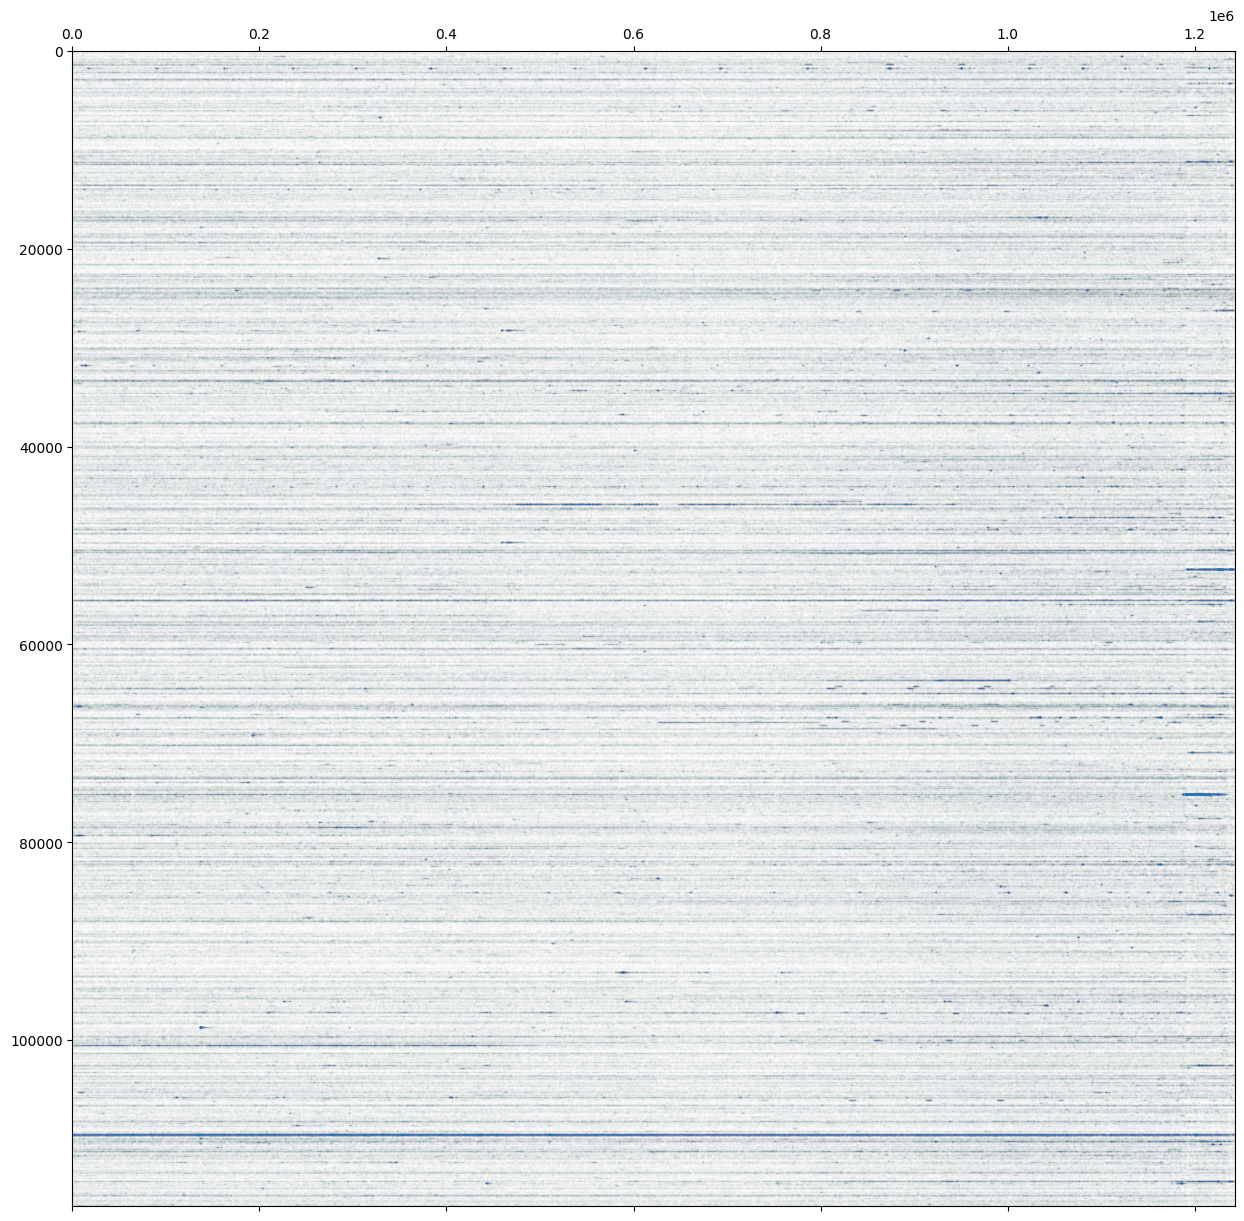

In [6]:
# 1.06 TiB for an array with shape (116795, 1242915)
#sparse_word_doc_matrix.toarray()


fig = figure(figsize=[15, 15])
sparse_word_doc_matrix_visualization = fig.add_subplot(1,1,1)

sparse_word_doc_matrix_visualization.spy(sparse_word_doc_matrix, markersize=0.0016, aspect = 'auto')



<Axes: >

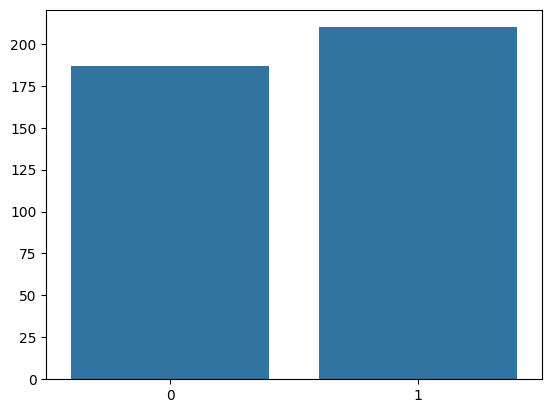

In [11]:

#SVD
#U,S,V
terms, concepts, documents = svds(sparse_word_doc_matrix, k=2)

fig = figure()
singular_values = fig.add_subplot(1,1,1)
 
sns.barplot(ax=singular_values,x=list(range(len(concepts))),y=concepts)


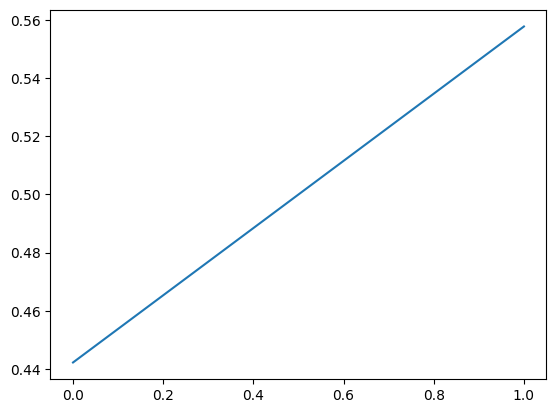

In [12]:

#square of singular values
concepts_sqr = np.power(concepts,2)
#sum of squares of the all the singular values
sum_concepts_sqr = np.sum(np.power(concepts,2))

fig = figure()
percent_variance = fig.add_subplot(1,1,1)

percent_variance.plot((concepts_sqr/sum_concepts_sqr))



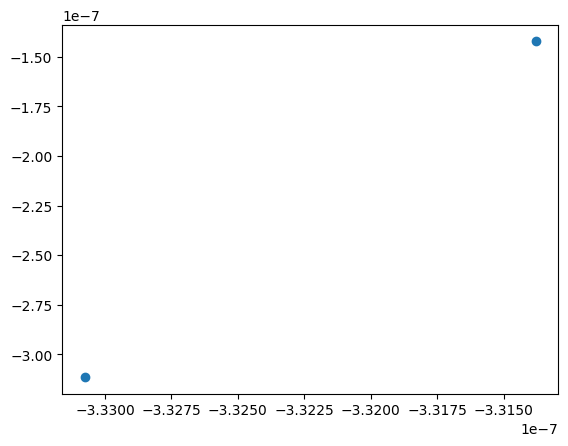

In [13]:
fig = figure()
term_plot = fig.add_subplot(1,1,1)

term_plot.scatter(terms[0],terms[1])

In [14]:

terms_df = pd.DataFrame(np.argsort(terms))
terms_df.applymap(dictionary_lookup.get)


,0,1
0,313,democracy'
1,313,democracy'
2,313,democracy'
3,313,democracy'
4,313,democracy'
...,...,...
116790,313,democracy'
116791,democracy',313
116792,democracy',313
116793,democracy',313
